# RADP RF Digital Twin + CCO Demo


# Prerequisite

### Ensure to install ffmpeg on your machine and create .env

Provide the executable ffmpeg file path in .env file.

Create .env file in root folder of repo and add below to env

`FFMPEG_PATH="/path_to_ffmpeg/ffmpeg"`


### Sample data set

Unpack the sample data set present at `notebooks/data/sim_data.zip` under `notebooks/data/`


In [45]:
import sys
from pathlib import Path
sys.path.append(f"{Path().absolute().parent}")

In [46]:
import numpy as np
from scipy import stats
from scipy.ndimage import correlate
from skimage.metrics import structural_similarity as ssim
from radp_library import *

## Using pregenerated data stored locally
Currently the data is stored under notebooks

/data folder

In [47]:
WORKING_DIR = f"{Path().absolute()}"
BUCKET_PATH = f"{WORKING_DIR}/data"
SIM_DATA_PATH = "sim_data/3cell"

## Bayesian digital twin training

In [48]:
# provide list of folder name under which the pregenerated data is stored
sim_idx_folders = ['sim_001', 'sim_002', 'sim_003', 'sim_004', 'sim_005']

[2024-09-10 13:52:31,692] INFO:  Iter 1/1 - Loss: 0.898 (delta=inf)
[2024-09-10 13:52:31,725] INFO:  Iter 1/1 - Loss: 0.898 (delta=inf)
[2024-09-10 13:52:31,756] INFO:  Iter 1/1 - Loss: 0.879 (delta=inf)
[2024-09-10 13:52:31,785] INFO:  Iter 1/1 - Loss: 0.870 (delta=inf)
[2024-09-10 13:52:31,815] INFO:  Iter 1/1 - Loss: 0.882 (delta=inf)


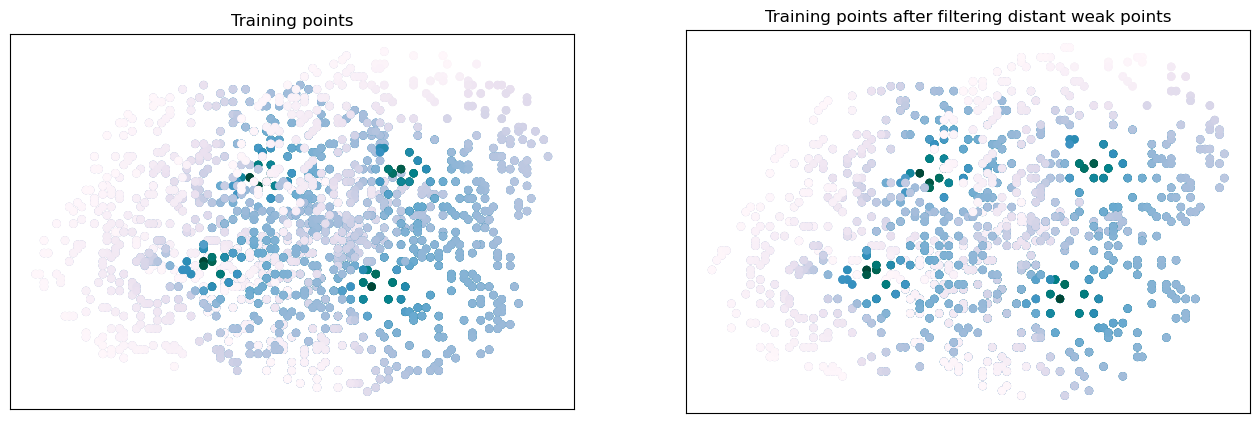

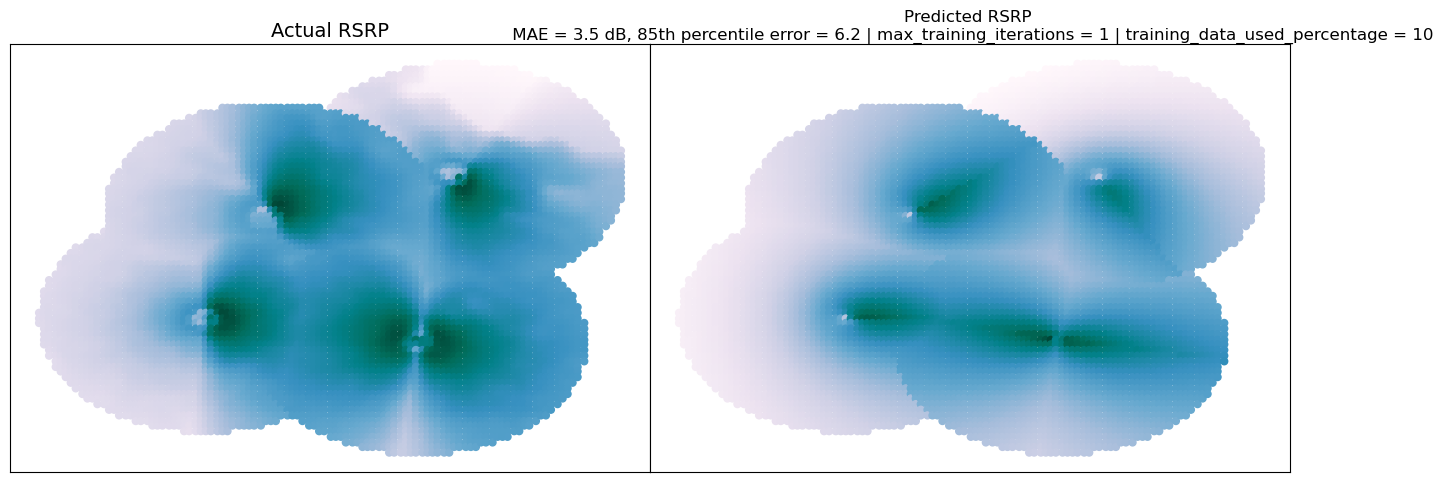

[2024-09-10 13:52:34,189] INFO:  Iter 1/2 - Loss: 0.904 (delta=inf)
[2024-09-10 13:52:34,204] INFO:  Iter 2/2 - Loss: 0.871 (delta=-0.033872)
[2024-09-10 13:52:34,239] INFO:  Iter 1/2 - Loss: 0.899 (delta=inf)
[2024-09-10 13:52:34,252] INFO:  Iter 2/2 - Loss: 0.868 (delta=-0.031433)
[2024-09-10 13:52:34,281] INFO:  Iter 1/2 - Loss: 0.879 (delta=inf)
[2024-09-10 13:52:34,297] INFO:  Iter 2/2 - Loss: 0.857 (delta=-0.022001)
[2024-09-10 13:52:34,329] INFO:  Iter 1/2 - Loss: 0.860 (delta=inf)
[2024-09-10 13:52:34,348] INFO:  Iter 2/2 - Loss: 0.842 (delta=-0.017583)
[2024-09-10 13:52:34,380] INFO:  Iter 1/2 - Loss: 0.883 (delta=inf)
[2024-09-10 13:52:34,398] INFO:  Iter 2/2 - Loss: 0.869 (delta=-0.013796)


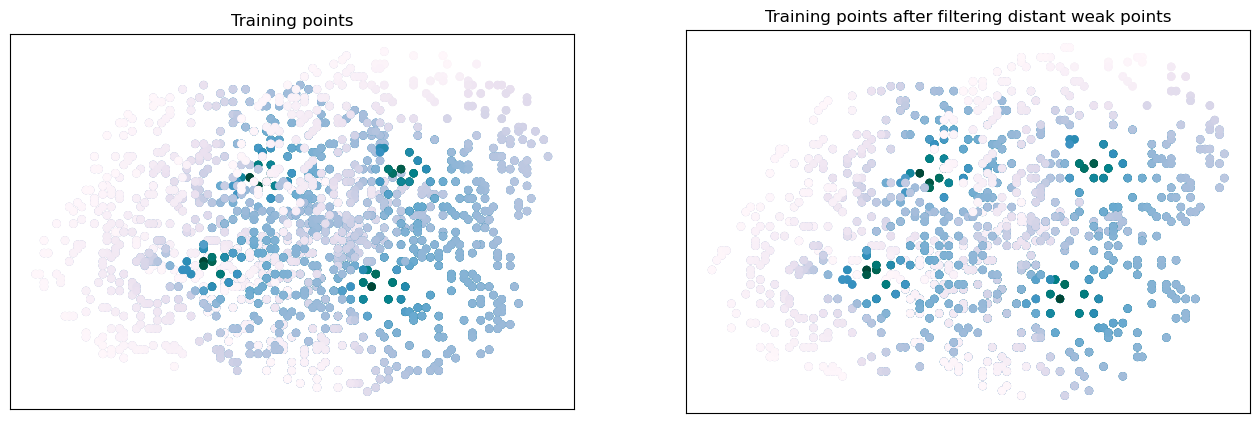

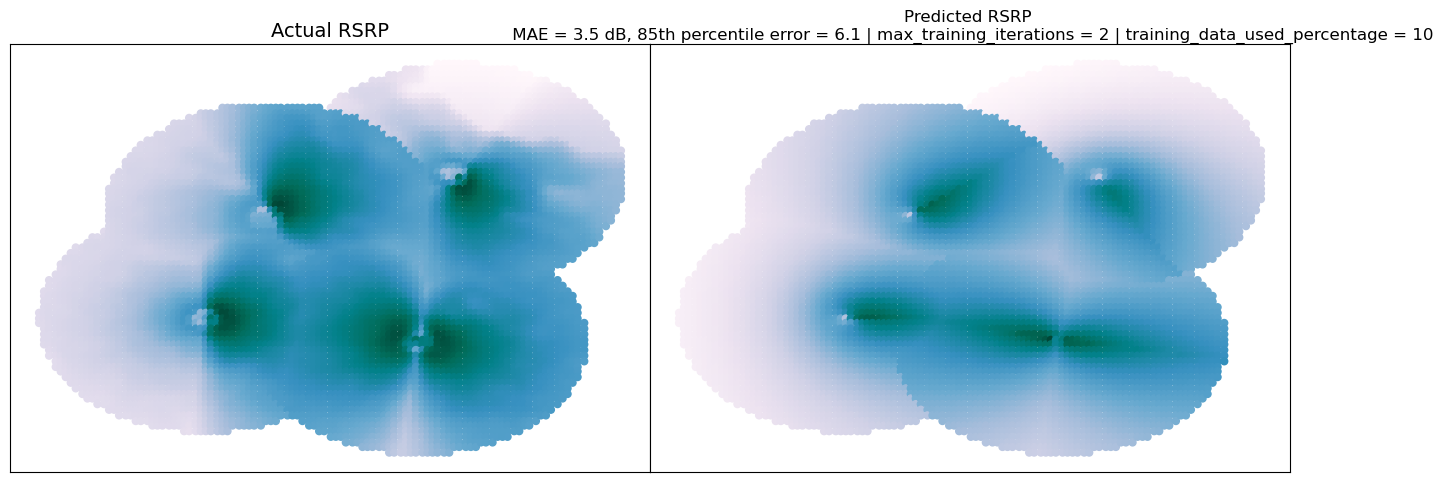

[2024-09-10 13:52:36,826] INFO:  Iter 1/10 - Loss: 0.825 (delta=inf)
[2024-09-10 13:52:36,964] INFO:  Iter 2/10 - Loss: 0.805 (delta=-0.019722)
[2024-09-10 13:52:37,100] INFO:  Iter 3/10 - Loss: 0.786 (delta=-0.019165)
[2024-09-10 13:52:37,235] INFO:  Iter 4/10 - Loss: 0.767 (delta=-0.019178)
[2024-09-10 13:52:37,366] INFO:  Iter 5/10 - Loss: 0.747 (delta=-0.019238)
[2024-09-10 13:52:37,495] INFO:  Iter 6/10 - Loss: 0.729 (delta=-0.018535)
[2024-09-10 13:52:37,623] INFO:  Iter 7/10 - Loss: 0.709 (delta=-0.019485)
[2024-09-10 13:52:37,751] INFO:  Iter 8/10 - Loss: 0.691 (delta=-0.018677)
[2024-09-10 13:52:37,877] INFO:  Iter 9/10 - Loss: 0.672 (delta=-0.018798)
[2024-09-10 13:52:38,002] INFO:  Iter 10/10 - Loss: 0.653 (delta=-0.018952)
[2024-09-10 13:52:38,143] INFO:  Iter 1/10 - Loss: 0.826 (delta=inf)
[2024-09-10 13:52:38,277] INFO:  Iter 2/10 - Loss: 0.806 (delta=-0.019377)
[2024-09-10 13:52:38,408] INFO:  Iter 3/10 - Loss: 0.788 (delta=-0.018318)
[2024-09-10 13:52:38,552] INFO:  Ite

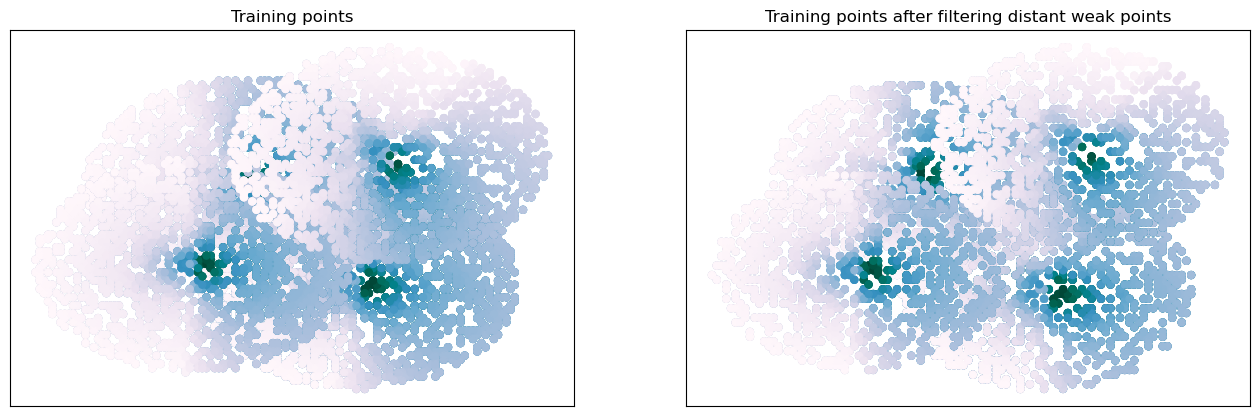

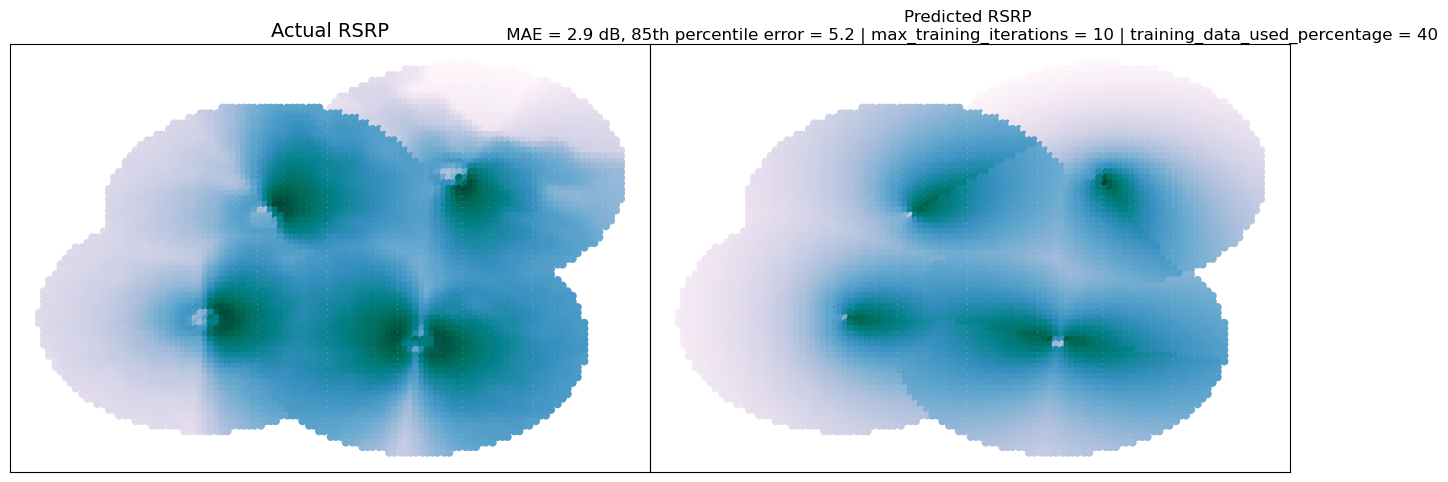

In [49]:
p_train_maxiter_dict = {
        10: [1, 2],
        40: [10]
}
p_test = 100

pred_rsrp_list = []
MAE_list = []
Percentile85Error_list = []
p_train_list = []
maxiter_list = []


for p_train in p_train_maxiter_dict.keys():
    for maxiter in p_train_maxiter_dict[p_train]:
        logging.info(f"\n\nMAXITER = {maxiter}, p_train={p_train}\n")
        _, site_config_df, test_data, loss_vs_iter, lons, lats, true_rsrp, pred_rsrp, MAE, Percentile85Error = bdt(
            bucket_path=BUCKET_PATH,
            sim_data_path=SIM_DATA_PATH,
            p_train=p_train,
            p_test=p_test,
            maxiter=maxiter,
            sim_idx_folders=sim_idx_folders,
            test_idx=2,
            plot_loss_vs_iter=True,
            choose_strongest_samples_percell=False,
            filter_out_samples_dbm_threshold=-70,
            filter_out_samples_kms_threshold=0.65,
            # track_sampling=True,
            # num_UEs=2,
            # ticks=100,
        )
        p_train_list.append(p_train)
        maxiter_list.append(maxiter)
        pred_rsrp_list.append(pred_rsrp)
        MAE_list.append(MAE)
        Percentile85Error_list.append(Percentile85Error)

df_results = pd.DataFrame(
    {
        "pred_rsrp_list": pred_rsrp_list,
        "MAE_list": MAE_list,
        "Percentile85Error_list": Percentile85Error_list,
        "maxiter_list": maxiter_list,
        "p_train_list": p_train_list,
    }
)

In [50]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [51]:
def get_2draster(lats ,lons, vals, z):
    min_lon_tile, min_lat_tile = lon_lat_to_bing_tile(min(lons), min(lats), level=z)
    max_lon_tile, max_lat_tile = lon_lat_to_bing_tile(max(lons), max(lats), level=z)

    val_dict = {}
    for lon, lat, val in zip(lons, lats, vals):
        lon_idx, lat_idx = lon_lat_to_bing_tile(lon, lat, level=z)
        row_idx = lat_idx - max_lat_tile
        col_idx = lon_idx - min_lon_tile
        if row_idx not in val_dict:
            val_dict[row_idx] = {}
        if col_idx not in val_dict[row_idx]:
            val_dict[row_idx][col_idx] = []
        val_dict[row_idx][col_idx].append(val)

    num_cols = max_lon_tile - min_lon_tile + 1
    num_rows = min_lat_tile - max_lat_tile + 1
    raster = np.empty((num_rows, num_cols))
    raster.fill(min(true_rsrp))
    for lat_idx in val_dict.keys():
        for lon_idx in val_dict[lat_idx].keys():
            if val_dict[lat_idx][lon_idx] == []:
                raster[lat_idx][lon_idx] = min(true_rsrp)
            else:
                raster[lat_idx][lon_idx] = np.average(val_dict[lat_idx][lon_idx])

    return raster

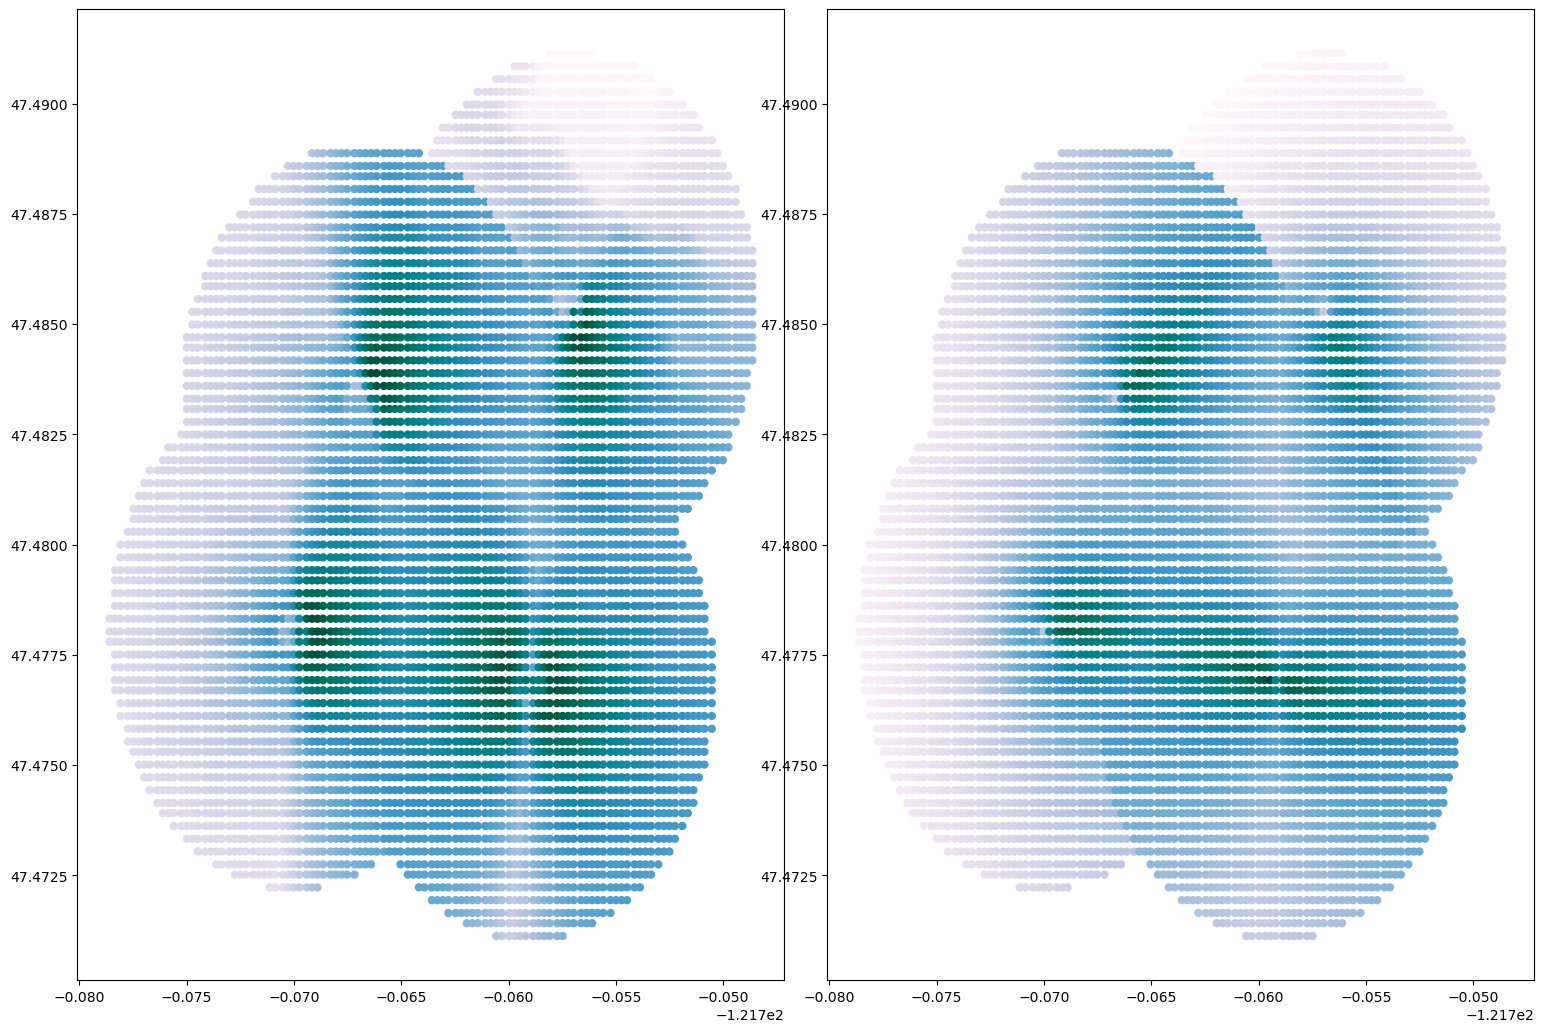

<Figure size 640x480 with 0 Axes>

In [52]:
df_results = pd.DataFrame(
    {
        "pred_rsrp_list": pred_rsrp_list,
        "MAE_list": MAE_list,
        "Percentile85Error_list": Percentile85Error_list,
        "maxiter_list": maxiter_list,
        "p_train_list": p_train_list,
    }
)

df_results["pearson_corr"] = df_results.apply(
    lambda x: stats.pearsonr(true_rsrp, x.pred_rsrp_list)[0], axis=1
)

perc = 99
df_results["tail_error"] = df_results.apply(
    lambda x: np.percentile(abs(true_rsrp - x.pred_rsrp_list), perc), axis=1
)


lambda_corr = 0.8

df_results["MAE_list_normalized_inverted"] = 1 - normalize_data(df_results[['MAE_list']])

df_results["tail_error_normalized_inverted"] = 1 - normalize_data(df_results[['tail_error']])

df_results["pearson_corr_normalized"] = normalize_data(df_results[['pearson_corr']])

df_results["Percentile85Error_list_normalized_inverted"] = 1 - normalize_data(df_results[['Percentile85Error_list']])

df_results["pearson_MAE_inverted_normalized_mean"] = df_results[['pearson_corr_normalized', 'MAE_list_normalized_inverted']].mean(axis=1)

df_results["pearson_Percentile85Error_inverted_normalized_mean"] = df_results[['pearson_corr_normalized','Percentile85Error_list_normalized_inverted']].mul(
    (lambda_corr, 1 -lambda_corr)
).sum(1)

df_results["pearson_tail_error_inverted_normalized_mean"] = df_results[['pearson_corr_normalized', 'tail_error_normalized_inverted']].mean(axis=1)


df_results["variance_error"] = df_results.apply(
    lambda x: np.var(true_rsrp - x.pred_rsrp_list), axis=1
)

df_results_sorted = df_results


anim, fig = animate_predictions(
    lats,
    lons,
    true_rsrp,
    df_results_sorted.pred_rsrp_list.to_list(),
    df_results_sorted.MAE_list.to_list(),
    df_results_sorted.Percentile85Error_list.to_list(),
    df_results_sorted.maxiter_list.to_list(),
    df_results_sorted.p_train_list.to_list(),
    "/tmp/animation_digital_twin_larger_network_iter_scanning_v4.mp4",
)

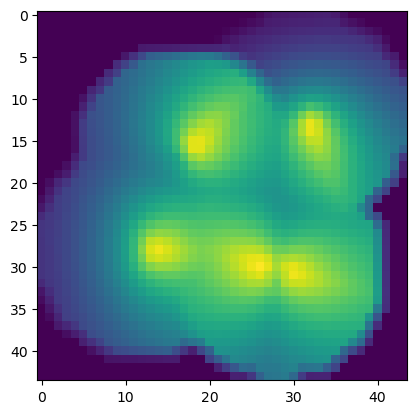

In [53]:
raster_true = get_2draster(lats, lons, df_results.pred_rsrp_list[2], 19)
weights = [[0, 1, 0],
           [1, 1, 1],
           [0, 1, 0]]
raster_true_smoothed = correlate(raster_true, weights, mode='nearest')
plt.imshow(raster_true_smoothed)

plt.plot(df_results["ssim"])

Error =  2.902889554951607
Correlation =  0.9631381803062743
25th percentile =  1.2169968606118289


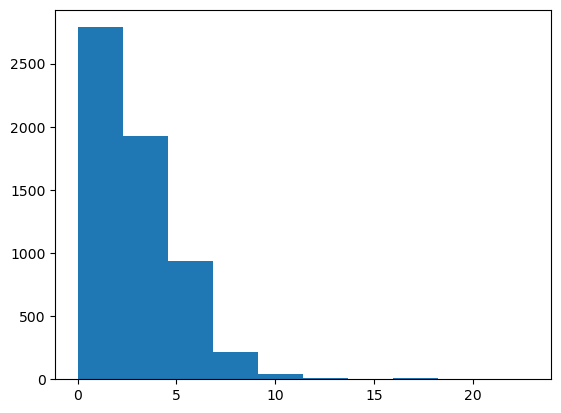

In [54]:
plt.hist(abs(true_rsrp - df_results_sorted.pred_rsrp_list.iloc[2]))
print("Error = ", df_results_sorted.MAE_list.iloc[2])
print("Correlation = ", df_results_sorted.pearson_corr.iloc[2])
print("25th percentile = ", np.percentile(abs(true_rsrp - df_results_sorted.pred_rsrp_list.iloc[2]), 25))

Error =  2.902889554951607
Correlation =  0.9631381803062743
25th percentile =  1.2169968606118289


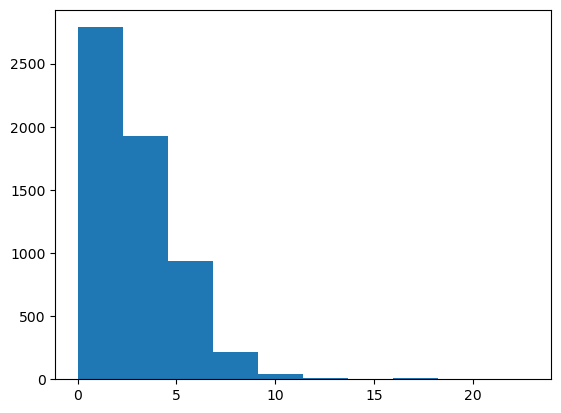

In [55]:
plt.hist(abs(true_rsrp - df_results_sorted.pred_rsrp_list.iloc[2]))
print("Error = ", df_results_sorted.MAE_list.iloc[2])
print("Correlation = ", df_results_sorted.pearson_corr.iloc[2])
print("25th percentile = ", np.percentile(abs(true_rsrp - df_results_sorted.pred_rsrp_list.iloc[2]), 25))

In [56]:
df_results_sorted.MAE_list

0    3.529765
1    3.452421
2    2.902890
Name: MAE_list, dtype: float64

In [ ]:
maxiters=[38]
p_train_list=[40]
_, site_config_df, test_data, loss_vs_iter, lons, lats, true_rsrp, pred_rsrp, MAE, Percentile85Error = bdt(
    bucket_path=BUCKET_PATH,
    sim_data_path=SIM_DATA_PATH,
    p_train=p_train_list[0],
    p_test=100,
    maxiter=maxiters[0],
    sim_idx_folders=sim_idx_folders,
    test_idx=2,
    plot_loss_vs_iter=True,
    choose_strongest_samples_percell=False,
    filter_out_samples_dbm_threshold=-70,
    filter_out_samples_kms_threshold=0.65,
)
animate_predictions(
    lats,
    lons,
    true_rsrp,
    [pred_rsrp],
    [MAE],
    [Percentile85Error],
    maxiters,
    p_train_list,
    "/tmp/animation_digital_twin_larger_network_iter_scanning_v5.mp4",
)

[2024-09-10 13:52:50,010] INFO:  Iter 1/38 - Loss: 0.824 (delta=inf)
[2024-09-10 13:52:50,163] INFO:  Iter 2/38 - Loss: 0.805 (delta=-0.019305)
[2024-09-10 13:52:50,305] INFO:  Iter 3/38 - Loss: 0.786 (delta=-0.018905)
[2024-09-10 13:52:50,469] INFO:  Iter 4/38 - Loss: 0.767 (delta=-0.019274)
[2024-09-10 13:52:50,628] INFO:  Iter 5/38 - Loss: 0.748 (delta=-0.019123)
[2024-09-10 13:52:50,796] INFO:  Iter 6/38 - Loss: 0.729 (delta=-0.018861)
[2024-09-10 13:52:50,968] INFO:  Iter 7/38 - Loss: 0.710 (delta=-0.019036)
[2024-09-10 13:52:51,136] INFO:  Iter 8/38 - Loss: 0.691 (delta=-0.018817)
[2024-09-10 13:52:51,306] INFO:  Iter 9/38 - Loss: 0.672 (delta=-0.019340)
[2024-09-10 13:52:51,447] INFO:  Iter 10/38 - Loss: 0.653 (delta=-0.018747)
[2024-09-10 13:52:51,586] INFO:  Iter 11/38 - Loss: 0.634 (delta=-0.019241)
[2024-09-10 13:52:51,720] INFO:  Iter 12/38 - Loss: 0.616 (delta=-0.018254)
[2024-09-10 13:52:51,851] INFO:  Iter 13/38 - Loss: 0.598 (delta=-0.017415)
[2024-09-10 13:52:51,982] I

[2024-09-10 13:53:06,436] INFO:  Iter 34/38 - Loss: 0.138 (delta=-0.024631)
[2024-09-10 13:53:06,606] INFO:  Iter 35/38 - Loss: 0.114 (delta=-0.024083)
[2024-09-10 13:53:06,762] INFO:  Iter 36/38 - Loss: 0.091 (delta=-0.022513)
[2024-09-10 13:53:06,940] INFO:  Iter 37/38 - Loss: 0.073 (delta=-0.017772)
[2024-09-10 13:53:07,106] INFO:  Iter 38/38 - Loss: 0.050 (delta=-0.023257)
[2024-09-10 13:53:07,299] INFO:  Iter 1/38 - Loss: 0.823 (delta=inf)
[2024-09-10 13:53:07,450] INFO:  Iter 2/38 - Loss: 0.804 (delta=-0.018639)
[2024-09-10 13:53:07,602] INFO:  Iter 3/38 - Loss: 0.785 (delta=-0.018925)
[2024-09-10 13:53:07,752] INFO:  Iter 4/38 - Loss: 0.767 (delta=-0.018337)
[2024-09-10 13:53:07,897] INFO:  Iter 5/38 - Loss: 0.748 (delta=-0.018471)
[2024-09-10 13:53:08,041] INFO:  Iter 6/38 - Loss: 0.730 (delta=-0.018018)


In [ ]:
df_results_sorted.pearson_corr

In [ ]:
df1 = pd.DataFrame(
    {
        "loc_x": [1.1, 2.3, 4.5],
        "loc_y": [-7.005, 68, 2.22],
        "pred_rsrp": [10, 10, 10],
        "cell_rxpwr_dbm": [12.0, 12.0, 12.0],
    }
)

df2 = pd.DataFrame(
    {
        "loc_x": [4.5, 1.1, 70.004],
        "loc_y": [2.22, -7.005, 2.22],
        "pred_rsrp": [20, 20, 20],
        "cell_rxpwr_dbm": [12.0000, 12.00001, 12.00001],
    }
)

pd.concat([df1, df2]).groupby(["loc_x", "loc_y"], as_index=False)[["pred_rsrp", "cell_rxpwr_dbm"]].max()

print(df1.apply(lon_lat_to_bing_tile_df_row, level=20, axis=1))
print(df1.apply(lon_lat_to_bing_tile_df_row, level=20, axis=1).apply(bing_tile_to_center_df_row, level=20, axis=1))
print(
    df1.apply(lon_lat_to_bing_tile_df_row, level=20, axis=1)
    .apply(bing_tile_to_center_df_row, level=20, axis=1)
    .apply(lon_lat_to_bing_tile_df_row, level=20, axis=1)
)
print(
    df1.apply(lon_lat_to_bing_tile_df_row, level=20, axis=1)
    .apply(bing_tile_to_center_df_row, level=20, axis=1)
    .apply(lon_lat_to_bing_tile_df_row, level=20, axis=1)
    .apply(bing_tile_to_center_df_row, level=20, axis=1)
)

In [ ]:
lons = test_data[1]["loc_x"].values
lats = test_data[1]["loc_y"].values

step = SRTM_STEP * 1.1

min_lon = min(lons)
max_lon = max(lons)
min_lat = min(lats)
max_lat = max(lats)
lon_dims = math.ceil((max_lon - min_lon) / step)
lat_dims = math.ceil((max_lat - min_lat) / step)

rf_raster = np.empty([lat_dims, lon_dims], dtype="float32")

for i in range(len(lons)):
    lon_idx = int((lons[i] - min_lon) / step)
    lat_idx = int((lats[i] - min_lat) / step)
    rf_raster[lat_idx][lon_idx] = pred_rsrp[i]

In [ ]:
shapes = rfco_to_best_server_shapes(
    spwr_src_raster=rf_raster,
    min_lat=min_lat,
    min_lon=min_lon,
    step=step,
)
raw_polys = [geometry.shape(shape[0]) for shape in shapes]

In [ ]:
len(raw_polys)

In [ ]:
# colors in ABGR order
line_style = fastkml.styles.LineStyle(color="7FFF3355", width=1)
poly_style = fastkml.styles.PolyStyle(color="88FFEEEE", fill=1, outline=1)
styles = fastkml.styles.Style(KML_NS, styles=[line_style, poly_style])

ShapesKMLWriter.shape_dict_to_kmz(
    {str(k): poly for k, poly in enumerate(raw_polys)},
    "shapes.kmz",
    styles=[styles],
    zipped=False,  # write as KML instead of KMZ for Mapbox viz
)

In [ ]:
plt.imshow(rf_raster)